In [8]:
from scipy.ndimage import rotate, shift
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import scipy.stats as sp
import pandas as pd
import statsmodels.api as sm
import math
import cmath
import seaborn as sns

In [9]:
#INPUT
stability = 1#set from 1-6                              

measured_x = 63                                                   
measured_y = 38                                                                                                             

stack_x = 34
stack_y = 13
stack_height = 4      
emission_rate = 100                                                                 
windspeed=4.7
wind_direction=90


In [10]:
#GRID & STEPSIZE CALCULATION 

stability_str = ['Very unstable', 'Moderately unstable', 'Slightly unstable', 'Neutral', 'Moderately stable', 'Very stable'] # Possibly Useless
ssv= stability_str[stability-1] # Possibly Useless
x_range=np.arange(-100,100,0.5)
y_range=np.arange(-100,100,0.5)
z_range=np.arange(0,50,0.5)
X,Y,Z = np.meshgrid(x_range,y_range,z_range)

In [11]:
#WIND RELATED CALCULATIONS

height_slice_direction= math.atan2(measured_y - stack_y, measured_x - stack_x) *(180/(math.pi))
x_origin=X-stack_x
y_origin=Y-stack_y

wind_xcomponent=windspeed*math.sin(math.radians(wind_direction-180))
wind_ycomponent=windspeed*math.cos(math.radians(wind_direction-180))

dot_product=wind_xcomponent*x_origin+wind_ycomponent*y_origin
magnitudes= windspeed*((x_origin**2)+(y_origin**2))**0.5
subtended=np.arccos(dot_product/(magnitudes+1e-5))
hypotenuse=((x_origin**2)+(y_origin**2))**0.5
downwind=np.cos(subtended)*hypotenuse
downwindimag=np.vectorize(complex)(downwind.real, downwind.imag)


In [12]:
#PASQUILL CONSTANTS & SIGMA CALCULATION

stability_class= {1 : (122.8,0.94470,24.1670,2.5334),
                  2: (90.673, 0.93198, 18.3330, 1.8096),
                  3: (61.141, 0.91465, 12.5, 1.0857),
                  4: (34.459, 0.86974, 8.3330, 0.72382),
                  5: (24.26, 0.83660, 6.25, 0.54287),
                  6: (15.209, 0.81558, 4.1667, 0.36191)
                 }
P_a=stability_class[stability][0] 
P_b=stability_class[stability][1]
P_c=stability_class[stability][2]
P_d=stability_class[stability][3]

sig_z = P_a*(abs((downwind/1000))**P_b)
sig_z[sig_z > 5000] = 5000
theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))
sig_y=(465.11628*downwind/1000)*np.tan(theta)

C:\Users\danin\AppData\Local\Temp\ipykernel_25488\2866074324.py:17: RuntimeWarning: divide by zero encountered in log
  theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))
C:\Users\danin\AppData\Local\Temp\ipykernel_25488\2866074324.py:17: RuntimeWarning: invalid value encountered in multiply
  theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))


In [13]:
#CROSSWIND AND GAUSSIAN FORMULA

crosswind=np.sin(subtended)*hypotenuse
indix,indiy,indiz=np.where((downwind > 0))
Concentration= np.zeros(np.shape(downwind))
Concentration[indix,indiy,indiz] =((emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz]))*(math.e**(-crosswind[indix,indiy,indiz]**2/(2*sig_y[indix,indiy,indiz]**2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))+ math.e**(-(Z[indix,indiy,indiz]+stack_height)**2/(2*sig_z[indix,indiy,indiz]**2)))))

#print(Concentration,np.shape(Concentration),len(x_range)*len(y_range))
#maybe way to calculate area of plume over whole facility

C:\Users\danin\AppData\Local\Temp\ipykernel_25488\2012047214.py:6: RuntimeWarning: invalid value encountered in power
  Concentration[indix,indiy,indiz] =((emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz]))*(math.e**(-crosswind[indix,indiy,indiz]**2/(2*sig_y[indix,indiy,indiz]**2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))+ math.e**(-(Z[indix,indiy,indiz]+stack_height)**2/(2*sig_z[indix,indiy,indiz]**2)))))
C:\Users\danin\AppData\Local\Temp\ipykernel_25488\2012047214.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  Concentration[indix,indiy,indiz] =((emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz]))*(math.e**(-crosswind[indix,indiy,indiz]**2/(2*sig_y[indix,indiy,indiz]**2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))+ math.e**(-(Z[indix,indiy,indiz]+stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))))

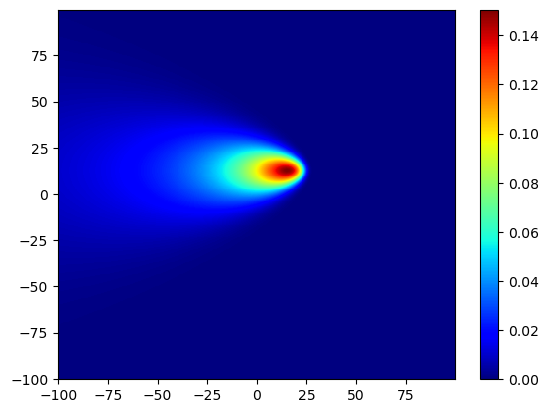

In [14]:
#PLOTTING IN 2D

Concentration2D=(Concentration[:,:, 0])
plt.figure()
pcm = plt.pcolor(x_range, y_range, Concentration2D[:,:], shading=None, cmap='jet')
plt.colorbar()